# Performance exploration - Calculating values that depend on neighboring values of ordered data in python.
Based on Q5 of the SQL mini project, the question was to find the largest change in closing price between any two days?
Additionally I wanted to be able to report the max change in price and the dates that it occured between.

In [1]:
#importing packages needed
import json
import requests
from itertools import islice
from collections import OrderedDict, namedtuple

In [2]:
# Reading Quandl API Key
with open('Api_key_NO_GIT.json', 'r') as f:
    j_data = json.load(f)
API_KEY = j_data.get('API_KEY')

# url constants:
base_url = "https://www.quandl.com/api/v3/datasets/FSE/AFX_X/data.json"
api_url = "api_key="+API_KEY

In [3]:
# Create named tuple used to store a day of Trade data retrieved from Quandle:
Tradeday = namedtuple('Tradeday', 'date open high low close change traded_vol turn_over last_price d_trad_unit d_turnover')


In [4]:
# Getting reference data sets - 255 data points 2017
afx_2017_url = base_url+"?start_date=2016-12-31&end_date=2018-01-01&"+api_url
r = requests.get(afx_2017_url)
sm_d = {d[0] : Tradeday(*d) for d in r.json()['dataset_data']['data']}
# Ensuring data is ordered by date
sm_d = OrderedDict(sorted(sm_d.items(), key=lambda t:t[0]))
print('{} trading days between {} and {}'.format(len(sm_d), min(sm_d), max(sm_d)))
print(list(sm_d.items())[0])

255 trading days between 2017-01-02 and 2017-12-29
('2017-01-02', Tradeday(date='2017-01-02', open=34.99, high=35.94, low=34.99, close=35.8, change=None, traded_vol=44700.0, turn_over=1590561.0, last_price=None, d_trad_unit=None, d_turnover=None))


In [5]:
# Getting reference data sets - 4643
afx_2017_url = base_url+"?"+api_url
r = requests.get(afx_2017_url)
md_d = {d[0] : Tradeday(*d) for d in r.json()['dataset_data']['data']}
# Ensuring data is ordered by date
md_d = OrderedDict(sorted(md_d.items(), key=lambda t:t[0]))
print('{} trading days between {} and {}'.format(len(md_d), min(md_d), max(md_d)))
print(list(md_d.items())[0])

4643 trading days between 2000-06-07 and 2018-06-07
('2000-06-07', Tradeday(date='2000-06-07', open=None, high=None, low=None, close=38.0, change=None, traded_vol=0.0, turn_over=None, last_price=None, d_trad_unit=None, d_turnover=0.0))


## Exploring the time taken for 3 one line solutions

Method 1 is a partial one liner using islice although its partial because it doesn't capture the date information 

In [6]:
def method1(data):
    # using islice in a list comprehension
    return max(
        (abs(v.close-next(islice(data.values(), i+1, i+2)).close), v.date, next(islice(data.values(), i+1, i+2)).date)
        for i, v in enumerate(data.values()) if i < len(data)-1)

Method 2 is a cleaner one line solution thank you @DyZ and <a href="https://stackoverflow.com/questions/50770868/best-way-to-calculate-max-diffs-between-items-in-a-dictionary" target="_blank">this SO question</a>. Although also missing the date information it got me on the right path.

In [7]:
def method2(data):
    # using zip to create tuples of neighbouring data
    ans = max(abs(u.close-v.close) for u,v in zip(list(data.values()),list(data.values())[1:]))
    return (ans,'n/a','n/a')

Method 3 is a complete one line solution - separated into two for readability:

In [8]:
def method3(data):
    # extention of method2 to get date information also in a tuple 
    return max([(abs(u.close-v.close), u.date, v.date) for u, v in zip(list(data.values()),list(data.values())[1:])])

In [9]:
methods = [method1, method2, method3]
answers =[(m.__name__, m(sm_d)) for m in methods]
for a in answers:
    (ans, fr_date, to_date) = a[1]
    print('{}: {:.2f}, Between trading days {} and {}'.format(a[0], ans, fr_date, to_date))

method1: 2.56, Between trading days 2017-08-08 and 2017-08-09
method2: 2.56, Between trading days n/a and n/a
method3: 2.56, Between trading days 2017-08-08 and 2017-08-09


In [10]:
%timeit method1(sm_d)

4.39 ms ± 637 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%timeit method2(sm_d)

110 µs ± 2.73 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%timeit method3(sm_d)

159 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [13]:
answers =[(m.__name__, m(md_d)) for m in methods]
for a in answers:
    (ans, fr_date, to_date) = a[1]
    print('{}: {:.2f}, Between trading days {} and {}'.format(a[0], ans, fr_date, to_date))

method1: 7.00, Between trading days 2000-06-08 and 2000-06-09
method2: 7.00, Between trading days n/a and n/a
method3: 7.00, Between trading days 2000-06-08 and 2000-06-09


In [14]:
%timeit method1(md_d)

960 ms ± 5.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit method2(md_d)

2.36 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%timeit method3(md_d)

3.36 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Exploring the time taken for 3 for loop solutions

In [17]:
#%%timeit
def method4(data): 
    #flatten data into list of (k,v) tuples and iterate over a range
    d_list = list(data.items())
    ans, fr_date, to_date  = 0, '', ''

    for i in range(len(data)-1):
        change = abs(d_list[i][1].close-d_list[i+1][1].close)
        if change > ans:
            ans, fr_date, to_date = change, d_list[i][1].date, d_list[i+1][1].date
    return (ans, fr_date, to_date)

In [18]:
#%%timeit
def method5(data): 
    # Avoiding creating a list in memory by using islice in loop to extract the data.
    ans, fr_date, to_date = 0, '', ''
    for i, v in enumerate(data.values()):
        if i < len(sm_d)-1:
            ch = abs(v.close-next(islice(data.values(), i+1, i+2)).close)
            if ch > ans:
                ans, fr_date, to_date = ch, v.date, next(islice(data.values(), i+1, i+2)).date
    return (ans, fr_date, to_date)

In [19]:
#%%timeit
def method6(data):
    # A simpler loop interator and two islices.
    ans, fr_date, to_date = 0, '', ''
    for i in range(len(data)-1):
        ch = abs(next(islice(data.values(), i, i+1)).close-next(islice(data.values(), i+1, i+2)).close)
        if ch > ans:
            ans, fr_date, to_date = ch, next(islice(data.values(), i, i+1)).date, next(islice(data.values(), i+1, i+2)).date
    return (ans, fr_date, to_date)

In [20]:
methods2 = [method4, method5, method6]
answers =[(m.__name__, m(sm_d)) for m in methods2]
for a in answers:
    (ans, fr_date, to_date) = a[1]
    print('{}: {:.2f}, Between trading days {} and {}'.format(a[0], ans, fr_date, to_date))

method4: 2.56, Between trading days 2017-08-08 and 2017-08-09
method5: 2.56, Between trading days 2017-08-08 and 2017-08-09
method6: 2.56, Between trading days 2017-08-08 and 2017-08-09


In [21]:
%timeit method4(sm_d)

130 µs ± 15.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [22]:
%timeit method5(sm_d)

1.62 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
%timeit method6(sm_d)

3.17 ms ± 704 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
answers =[(m.__name__, m(md_d)) for m in methods2]
for a in answers:
    (ans, fr_date, to_date) = a[1]
    print('{}: {:.2f}, Between trading days {} and {}'.format(a[0], ans, fr_date, to_date))

method4: 7.00, Between trading days 2000-06-08 and 2000-06-09
method5: 7.00, Between trading days 2000-06-08 and 2000-06-09
method6: 7.00, Between trading days 2000-06-08 and 2000-06-09


In [25]:
%timeit method4(md_d)

3.69 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%timeit method5(md_d)

2.5 ms ± 76.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%timeit method6(md_d)

1.15 s ± 261 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Results Summary

| Method | Desc | Test | Results |
|---|:---:|---|:---|
| method1 | islice in list comp | sm: | 3 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)<br/>4.39 ms ± 637 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
| | | md: | 489 ms ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br>960 ms ± 5.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) |
| method2 | zip in list comp partial | sm: | 112 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)<br>110 µs ± 2.73 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
| | | md: | 2.49 ms ± 433 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)<br>2.36 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 100 loops each) |
| method3 | zip in list comp full | sm: | 160 µs ± 1.85 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)<br>      159 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
| | | md: | 4.08 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)<br>3.36 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each) |
| method4 | for loop list in memory | sm: | 123 µs ± 5.35 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)<br>130 µs ± 15.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
| | | md: | 2.61 ms ± 92.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)<br>3.69 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 100 loops each) |
| method5 | for loop on enumerate values and islice | sm: | 1.73 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)<br>     1.62 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
| | | md: | 2.86 ms ± 416 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)<br>2.5 ms ± 76.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each) |
| method6 | simple range for loop two islices | sm: | 2.98 ms ± 29.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)<br>     3.17 ms ± 704 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
| | | md: | 1.15 s ± 235 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br>1.15 s ± 261 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) |


When we only have 255 days of data method4 (pulling the entire list into memory and running a simple for loop over it) was quickest at ~123µs with method3 (the full zip in list comprehension) a close second at 160 µs

When we are dealing with the larger (but still really quite small) data set with 4643 days of data then method4 (list in memory) was still one of the fastest however method5 (the enumerate in for loop using islice) was performing just as well. method3 (the full zip in list comprehension) was just a little behind these two.

method1 (islice in list comp) and method6 (simple range for loop with two islices) were slow and got horribly slow.

The only method that didn't seem to slow down at a faster rate than the change in N (255->4643) was method5, I'm thinking that is because it uses efficient enumeration to calculate the change and only gets the islice date information when the change is larger than the currently tracked change - ie not for every change calculation. This will depend on the data being tested so is definately not worst case.

Here's a quick and dirty visualization of the results gathered here:

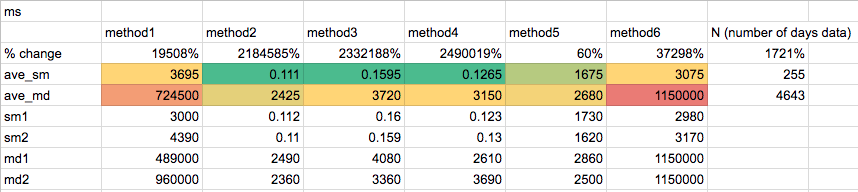

In [29]:
from IPython.display import Image
Image("results_viz.png")